In [2]:
import warnings
warnings.simplefilter(action='ignore')
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

 captum (see https://github.com/pytorch/captum).


In [10]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [12]:
# Load reference and query datasets
reference = sc.read('tyser.h5ad')  # Reference dataset
query = sc.read('hiPSC.h5ad')  # Query dataset

In [13]:
adata.X = adata.X.copy()

In [14]:
# Add batch information
reference.obs['batch'] = 'reference'  # Reference batch
query.obs['batch'] = 'query'  # Query batch


In [15]:
# Combine reference and query datasets
adata = reference.concatenate(query, batch_key='batch', batch_categories=['reference', 'query'])


In [16]:

sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)


In [17]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [18]:
sc.pp.normalize_total(adata)

In [19]:
sc.pp.log1p(adata)

In [20]:
# Select highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key='batch',  # Batch correction
    subset=True
)


In [23]:
select_terms = adata.varm['I'].sum(0) > 12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [24]:
adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [35]:
# Define scArches model (using Expimap as an example)
model = sca.models.EXPIMAP(
    adata=adata,
    condition_key='batch',  # Batch key specifies the dataset
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'  # Use negative binomial loss for scRNA-seq
    
)




INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1963 256 2
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 234
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  234 0 0 2 1963
	with hard mask.
Last Decoder layer: softmax


In [32]:
ALPHA = 0,7

In [36]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
model.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (5763, 1963)
Instantiating dataset
Init the group lasso proximal operator for the main terms.


TypeError: can't multiply sequence by non-int of type 'float'

In [27]:
sc.pp.neighbors(adata)

In [28]:
sc.tl.umap(adata)

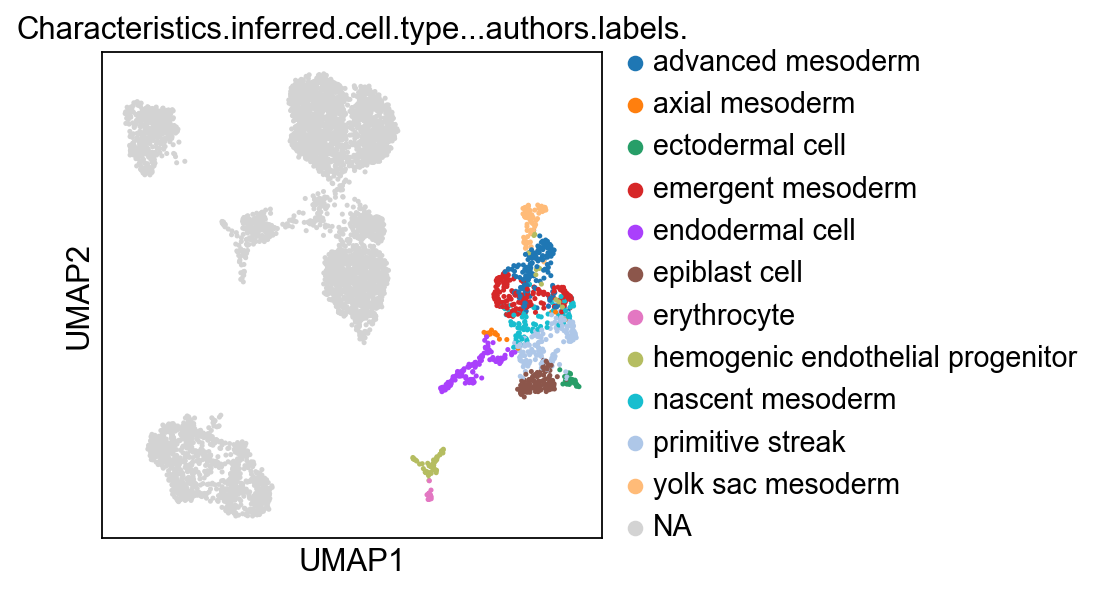

In [30]:
sc.pl.umap(adata, color='Characteristics.inferred.cell.type...authors.labels.')

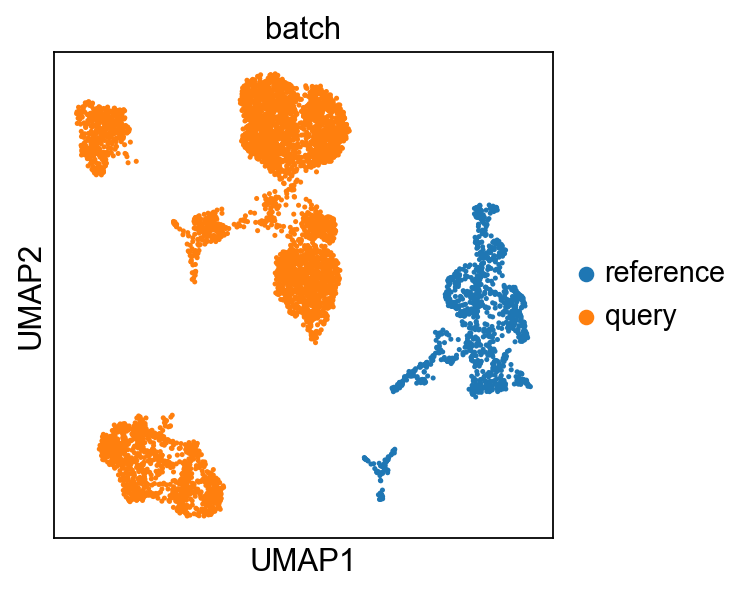

In [31]:
sc.pl.umap(adata, color='batch')